In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import logging
import warnings
import xarray as xr
from matplotlib import pyplot as plt
from dask.distributed import Client

from disp_xr.log.logging import setup_logging
from disp_xr import product, stack as disp_stack, utils, quality_metrics

logger = logging.getLogger('disp_xr')
setup_logging(logger_name='disp_xr')

In [9]:
import matplotlib.patches as patches
def plot_chunk_location(ax, stack_xr: xr.Dataset, 
                        block:tuple, annot_txt:str, zorder:int=1):
    # Get coordinates 
    start_y = stack_xr.isel(y=block[1]).y.data[0]
    stop_y = stack_xr.isel(y=block[1]).y.data[-1]
    start_x = stack_xr.isel(x=block[2]).x.data[0]
    stop_x = stack_xr.isel(x=block[2]).x.data[-1]

    # Compute center of the rectangle
    center_x = (start_x + stop_x) / 2
    center_y = (start_y + stop_y) / 2

    # Create recangular
    rect = patches.Rectangle((start_x, start_y), 
                             stop_x - start_x, 
                             stop_y - start_y,
                             facecolor='none',
                             linewidth=1,
                             edgecolor='k',
                             zorder=zorder)
    
    # Plot 
    ax.add_patch(rect)

    # Annotate the center
    ax.text(center_x, center_y, str(annot_txt),
            ha="center", va="center", fontsize=8, zorder=zorder)    

In [2]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/8622')

[INFO|product|L23] 2025-02-17T17:22:07-0800: Found OPERA DISP: 254 products
[INFO|product|L42] 2025-02-17T17:22:07-0800:  Starting date: 2016-07-16 22:50:42
[INFO|product|L43] 2025-02-17T17:22:07-0800:  Ending date: 2024-06-16 22:51:24
[INFO|product|L46] 2025-02-17T17:22:07-0800:  Number of reference dates: 8


[INFO|product|L84] 2025-02-17T17:22:07-0800:  Skip 30 duplicates


In [3]:
stack = disp_stack.combine_disp_product(disp_df)
stack = stack.chunk({'time':-1})

[INFO|stack|L24] 2025-02-17T17:22:08-0800: Stacking ministack into common stack
[INFO|stack|L26] 2025-02-17T17:22:08-0800:  Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
[INFO|logging|L75] 2025-02-17T17:22:22-0800: Total elapsed time for disp_xr.stack.combine_disp_product: 0.23 minutes (13.92 seconds)


In [11]:
client = Client()
client.dashboard_link

'http://127.0.0.1:8787/status'

In [14]:
# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)

# Plot one chip for dev
ix = 141
small_stack = stack.isel(y=chunks_ix[ix][1], x=chunks_ix[ix][2])
mask = small_stack.recommended_mask.isel(time=0)==1
small_stack.displacement.isel(time=0).where(mask).plot.imshow()

In [15]:
# Get stack quality metrics
pct_ps = quality_metrics.get_ps_percentage(small_stack)
pct_mask = quality_metrics.get_mask_percentage(small_stack) 
pct_conncomp = quality_metrics.get_conncomp_percentage(small_stack, reverse=True)
mean_tcoh = quality_metrics.get_tcoh_stat(small_stack)
mean_psim = quality_metrics.get_phasesim_stat(small_stack)
mean_pcor = quality_metrics.get_phasecorr_stat(small_stack)  

[INFO|quality_metrics|L60] 2025-02-14T14:03:17-0800: Get percentage of PS
[INFO|quality_metrics|L71] 2025-02-14T14:03:19-0800: Get percentage of recommended mask
[INFO|quality_metrics|L83] 2025-02-14T14:03:20-0800: Get percentage of valid connected components
[INFO|quality_metrics|L118] 2025-02-14T14:03:22-0800: Get mean temporal coherence
[INFO|quality_metrics|L96] 2025-02-14T14:03:23-0800: Get mean phase similarity
[INFO|quality_metrics|L129] 2025-02-14T14:03:25-0800: Get mean  estimated_phase_quality


In [16]:
fig, axs = plt.subplots(2,3, figsize=(12,12))

txt = ['pct of recommended mask',
       'pct of valid conncomp',
       'pct of ps stabilty',
       'mean temp. coh.',
       'mean phase sim.',
       'mean est. phase quality']
vars = [pct_mask, pct_conncomp, pct_ps,
        mean_tcoh, mean_psim, mean_pcor]
im =[]
for ix, (t, v, ax) in enumerate(zip(txt, vars, axs.ravel())):
    im.append(ax.imshow(v))
    ax.set_title(t) 

for ax, i in zip(axs.ravel(), im):
    fig.colorbar(i, ax=ax, location='bottom')

In [17]:
# Explore other stats for temporal coherence
tcoh_stats = {}

for mode in ['mean', 'median', 'min', 'max', 'std', 'var']:
    tcoh_stats[mode] = quality_metrics.get_tcoh_stat(small_stack, mode)

[INFO|quality_metrics|L118] 2025-02-14T14:03:50-0800: Get mean temporal coherence
[INFO|quality_metrics|L118] 2025-02-14T14:03:52-0800: Get median temporal coherence
[INFO|quality_metrics|L118] 2025-02-14T14:03:59-0800: Get min temporal coherence
[INFO|quality_metrics|L118] 2025-02-14T14:04:01-0800: Get max temporal coherence
[INFO|quality_metrics|L118] 2025-02-14T14:04:02-0800: Get std temporal coherence
[INFO|quality_metrics|L118] 2025-02-14T14:04:04-0800: Get var temporal coherence


In [18]:
# PLOT
fig, axs = plt.subplots(2,3, figsize=(10,8), sharey=True)

for ax, (tcoh_key, tcoh_value) in zip(axs.ravel(), tcoh_stats.items()):
    im = (ax.imshow(tcoh_value))
    ax.set_title(tcoh_key.upper())
    fig.colorbar(im, ax=ax, location='bottom', pad=0.2, shrink=0.6)
plt.tight_layout()

[INFO|quality_metrics|L107] 2025-02-14T14:04:12-0800: Get mean shp count


[INFO|quality_metrics|L107] 2025-02-14T14:04:14-0800: Get median shp count
[INFO|quality_metrics|L107] 2025-02-14T14:04:22-0800: Get min shp count
[INFO|quality_metrics|L107] 2025-02-14T14:04:23-0800: Get max shp count
[INFO|quality_metrics|L107] 2025-02-14T14:04:25-0800: Get std shp count
[INFO|quality_metrics|L107] 2025-02-14T14:04:27-0800: Get var shp count


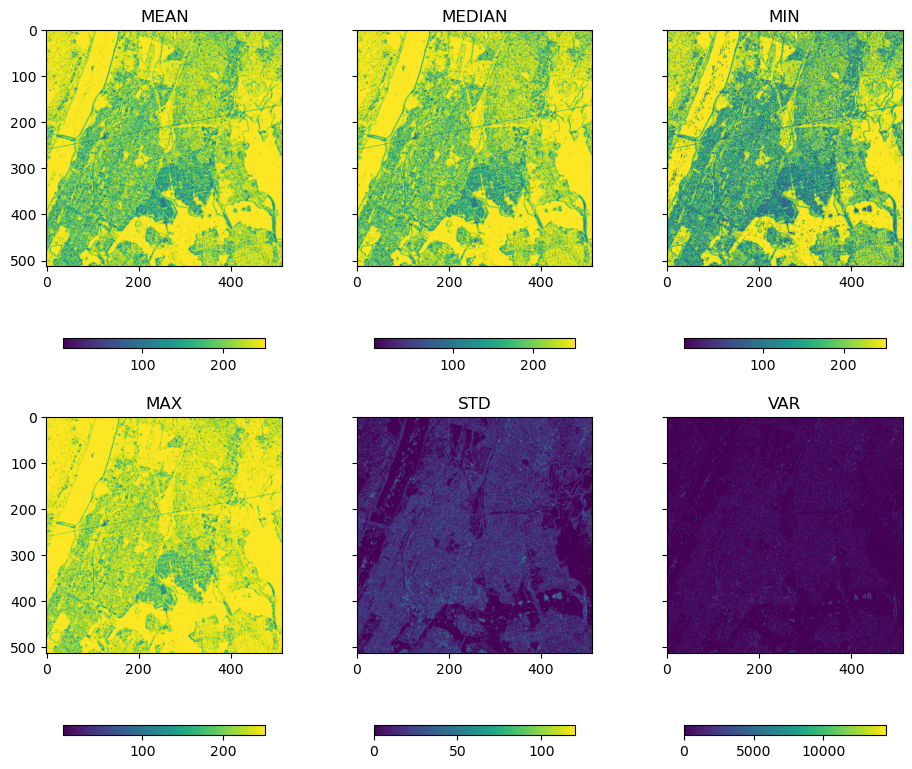

In [ ]:
# Explore other stats for temporal coherence
shp_stats = {}

for mode in ['mean', 'median', 'min', 'max', 'std', 'var']:
    shp_stats[mode] = quality_metrics.get_shpcount_stat(small_stack, mode)

# PLOT
fig, axs = plt.subplots(2,3, figsize=(10,8), sharey=True)

for ax, (shp_key, shp_value) in zip(axs.ravel(), shp_stats.items()):
    im = (ax.imshow(shp_value))
    ax.set_title(shp_key.upper())
    fig.colorbar(im, ax=ax, location='bottom', pad=0.2, shrink=0.6)
plt.tight_layout()

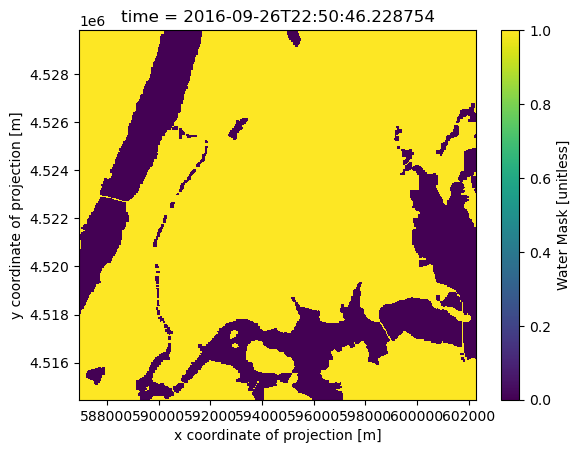

In [21]:
# Plot water mask
small_stack.isel(time=0).water_mask.plot.imshow()

## FULL FRAME METRICS

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    shp_median = quality_metrics.get_shpcount_stat(stack, 'median')
    shp_std = quality_metrics.get_shpcount_stat(stack, 'std')

In [36]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
im1 = axs[0].imshow(shp_median)
im2 = axs[1].imshow(shp_std)
for im, ax in zip([im1, im2], axs):
    fig.colorbar(im, ax=ax, location='bottom')

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    tcoh_median = quality_metrics.get_tcoh_stat(stack, 'median')
    tcoh_std = quality_metrics.get_tcoh_stat(stack, 'std')

[INFO|quality_metrics|L118] 2025-02-14T14:13:26-0800: Get median temporal coherence
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 49.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
[INFO|quality_metrics|L118] 2025-02-14T14:19:43-0800: Get std temporal coherence


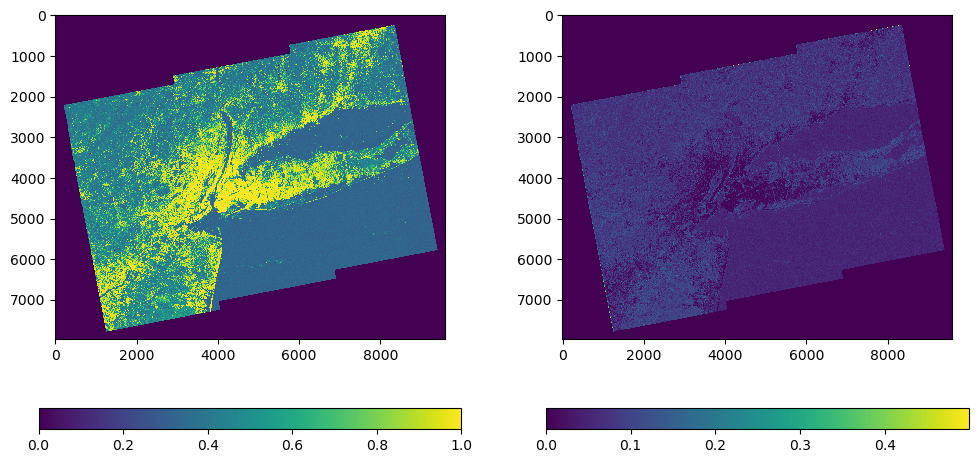

In [34]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
im1 = axs[0].imshow(tcoh_median, interpolation='nearest')
im2 = axs[1].imshow(tcoh_std, interpolation='nearest')
for im, ax in zip([im1, im2], axs):
    fig.colorbar(im, ax=ax, location='bottom')

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    psim_median = quality_metrics.get_phasesim_stat(stack, 'median')
    psim_std = quality_metrics.get_phasesim_stat(stack, 'std')

[INFO|quality_metrics|L96] 2025-02-14T14:26:10-0800: Get median phase similarity


[INFO|quality_metrics|L96] 2025-02-14T14:32:05-0800: Get std phase similarity


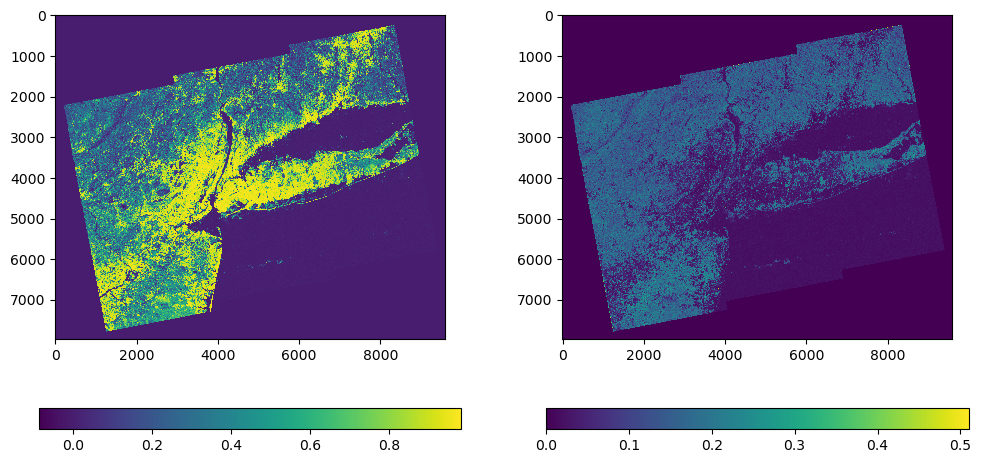

In [35]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
im1 = axs[0].imshow(psim_median, interpolation='nearest')
im2 = axs[1].imshow(psim_std, interpolation='nearest')
for im, ax in zip([im1, im2], axs):
    fig.colorbar(im, ax=ax, location='bottom')

# Use v0.1 to check residuals

In [37]:
# Get DISP version 0.10 data
disp_df = product.get_disp_info('/u/duvel-d0/ssangha/DISP_work/v10/F11116/products')

[INFO|product|L23] 2025-02-14T15:09:38-0800: Found OPERA DISP: 314 products
[INFO|product|L42] 2025-02-14T15:09:38-0800:  Starting date: 2016-07-05 14:07:55
[INFO|product|L43] 2025-02-14T15:09:38-0800:  Ending date: 2024-10-03 14:08:37
[INFO|product|L46] 2025-02-14T15:09:38-0800:  Number of reference dates: 9
[INFO|product|L84] 2025-02-14T15:09:38-0800:  Skip 0 duplicates


In [38]:
stack = disp_stack.combine_disp_product(disp_df)
stack = stack.chunk({'time':-1})

[INFO|stack|L24] 2025-02-14T15:10:02-0800: Stacking ministack into common stack
[INFO|stack|L26] 2025-02-14T15:10:02-0800:  Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
[INFO|logging|L75] 2025-02-14T15:20:39-0800: Total elapsed time for disp_xr.stack.combine_disp_product: 10.61 minutes (636.70 seconds)


In [40]:
# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)

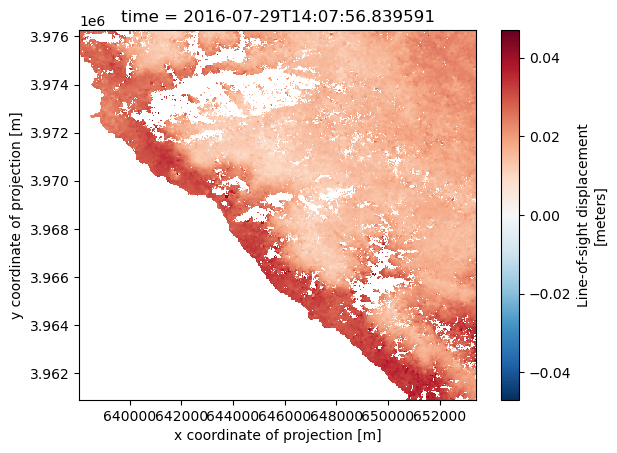

In [41]:
# Plot one chip for dev
fig, ax = plt.subplots()
ix =180 
mask = stack.recommended_mask[chunks_ix[ix]].isel(time=0)==1
stack.displacement[chunks_ix[ix]].isel(time=0).where(mask).plot.imshow(ax=ax)

In [42]:
stack

<xarray.Dataset> Size: 917GB
Dimensions:                         (time: 314, y: 6898, x: 9618)
Coordinates:
  * y                               (y) float64 55kB 4.114e+06 ... 3.908e+06
  * x                               (x) float64 77kB 4.998e+05 ... 7.883e+05
  * time                            (time) datetime64[ns] 3kB 2016-07-29T14:0...
Data variables: (12/13)
    spatial_ref                     (time) int64 3kB dask.array<chunksize=(314,), meta=np.ndarray>
    reference_time                  (time) datetime64[ns] 3kB dask.array<chunksize=(314,), meta=np.ndarray>
    displacement                    (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    short_wavelength_displacement   (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    recommended_mask                (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    connected_component_labels      (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    persistent_scatterer_mask       (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    shp_counts                      (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    water_mask                      (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    phase_similarity                (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
    timeseries_inversion_residuals  (time, y, x) float32 83GB dask.array<chunksize=(314, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [45]:
sum_residuals = quality_metrics.get_inv_residuals_stat(stack.isel(y=chunks_ix[ix][1], x=chunks_ix[ix][2]))

[INFO|quality_metrics|L140] 2025-02-14T15:25:19-0800: Get sum timeseries_inversion_residuals


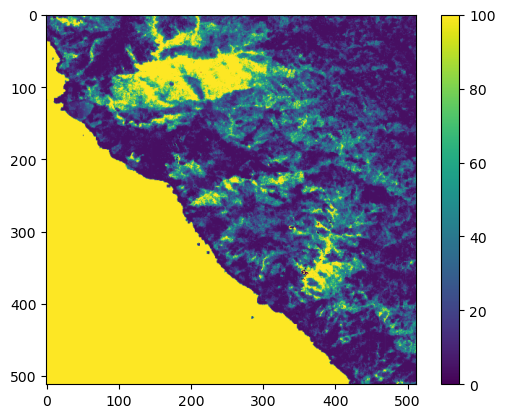

In [50]:
import numpy as np
plt.imshow(sum_residuals / (2*np.pi), clim=[0,100])
plt.colorbar()

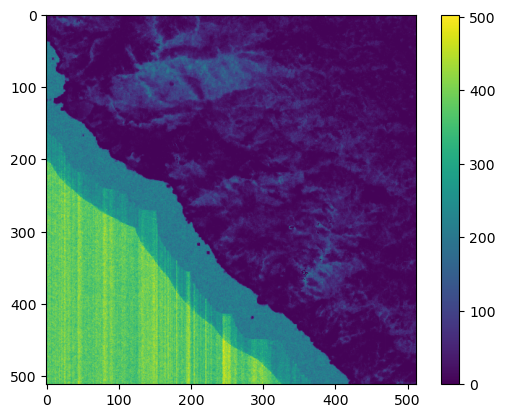

In [51]:
plt.imshow(sum_residuals / (2*np.pi))
plt.colorbar()

In [52]:
sum_residuals_frame = quality_metrics.get_inv_residuals_stat(stack)

[INFO|quality_metrics|L140] 2025-02-14T15:27:54-0800: Get sum timeseries_inversion_residuals
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 60.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


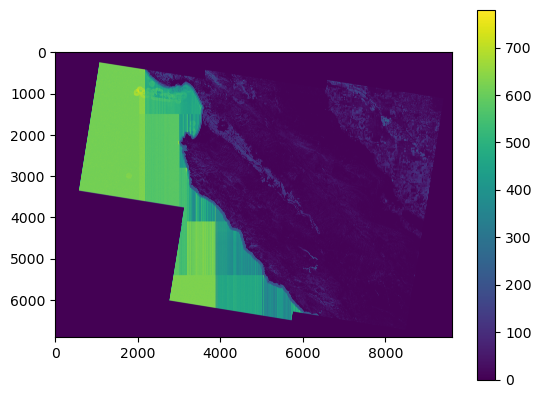

In [53]:
plt.imshow(sum_residuals_frame / (2*np.pi))
plt.colorbar()

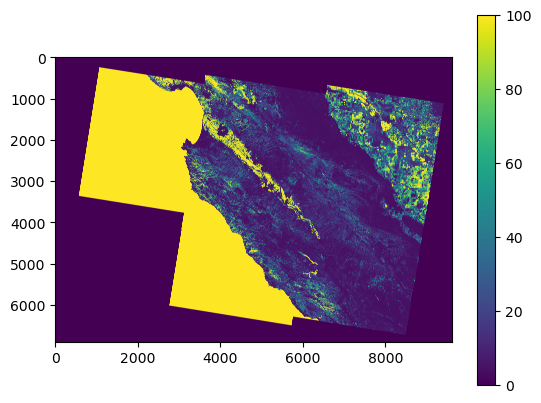

In [54]:
plt.imshow(sum_residuals_frame / (2*np.pi), clim=[0,100])
plt.colorbar()

In [55]:
client.close()